In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import scipy
from scipy.optimize import curve_fit

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
def N_avg(a, N=7):
    # weekly avg into the past, shorten a
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

def N_avg_hard(a, N=3):
    # hard edged rolling avg, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    b[:] = np.nan
    for i in range(N,len(a)-N,1):
        b[i] = np.mean(a[i-N:i+N])
    return b

def N_avg_soft(a, N=3):
    # soft edged rolling avg, preseve len a 
    b = np.zeros(len(a))
    for i in range(len(a)):
        l = max(0,i-N)
        r = min(i+N+1, len(a))
        b[i] = np.mean(a[l:r])
    return b

def diff_axis(scale, ax1, ax2):
    _,l1 = ax1.get_ylim()
    _,l2 = ax2.get_ylim()
    d1 = np.array(ax1.lines[0].get_ydata())
    d2 = np.array(ax2.lines[0].get_ydata())
    return np.mean(np.abs(d1/scale-d2))
    
def match_axis(ax1, ax2):
    scale = scipy.optimize.minimize(diff_axis, 1, args=(ax1,ax2))
    _,l2 = ax2.get_ylim()
    ax1.set_ylim(0,l2*scale.x)  
    return scale.x

In [3]:
# download api data for England
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newAdmissions&metric=covidOccupiedMVBeds&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_england = pd.DataFrame(response['body'])
df_england['dateTime'] = pd.to_datetime(df_england['date'])
df_england.sort_values(by=['dateTime'], inplace=True)
df_england.dropna(inplace=True)

top_date = sorted(list(set(df_england.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date)

2021-12-29


In [4]:
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nhsRegion&metric=newAdmissions&metric=covidOccupiedMVBeds&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_regions = pd.DataFrame(response['body'])
df_regions['dateTime'] = pd.to_datetime(df_regions['date'])
df_regions.sort_values(by=['dateTime'], inplace=True)
df_regions.dropna(inplace=True)

top_date = sorted(list(set(df_regions.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date)

2021-12-29


In [5]:
# input defs
train_in_stream = []
train_out_stream = []
dates_train = []
test_in_stream = []
test_out_stream = []
dates_test = []

in_event = ""
out_event = ""
geographical_context = ""

train_start_date = "2020-10-01" 
train_end_date = "2021-04-01"
test_start_date = "2021-09-20"
test_end_date = top_date

#train_start_date = "2021-07-01" 
#train_end_date = "2021-12-01"
#test_start_date = "2021-10-01"
#test_end_date = top_date

In [6]:
# set data: England +ve tests -> hosp admissions
df = df_england
train_df = df[(df.dateTime >= train_start_date) & (df.dateTime <= train_end_date)]
test_df = df[(df.dateTime >= test_start_date) & (df.dateTime <= test_end_date)]

train_in_stream = np.array(train_df.newAdmissions.to_list(), dtype=float)
train_out_stream = np.array(train_df.covidOccupiedMVBeds.to_list(), dtype=float)
test_in_stream = np.array(test_df.newAdmissions.to_list(), dtype=float)
test_out_stream = np.array(test_df.covidOccupiedMVBeds.to_list(), dtype=float)
dates_train = sorted(list(set(train_df.dateTime.to_list())))
dates_test = sorted(list(set(test_df.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "admitted"
out_event = "mv bed occup"
geographical_context = "England"

In [7]:
# set data: Regional +ve tests -> hosp admissions
region = "London"
df = df_regions[df_regions.areaName==region]

train_df = df[(df.dateTime >= train_start_date) & (df.dateTime <= train_end_date)]
test_df = df[(df.dateTime >= test_start_date) & (df.dateTime <= test_end_date)]

train_in_stream = np.array(train_df.newAdmissions.to_list(), dtype=float)
train_out_stream = np.array(train_df.covidOccupiedMVBeds.to_list(), dtype=float)
test_in_stream = np.array(test_df.newAdmissions.to_list(), dtype=float)
test_out_stream = np.array(test_df.covidOccupiedMVBeds.to_list(), dtype=float)
dates_train = sorted(list(set(train_df.dateTime.to_list())))
dates_test = sorted(list(set(test_df.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "admitted"
out_event = "mv bed occup"
geographical_context = region

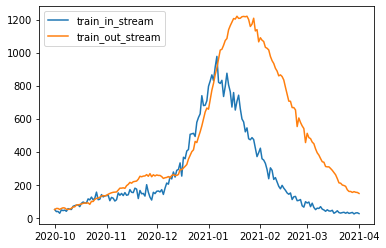

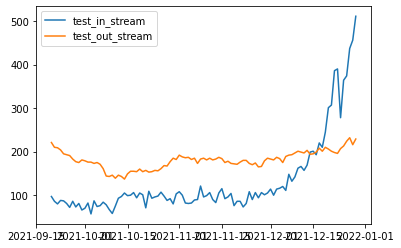

In [8]:
plt.clf()
plt.plot(dates_train, train_in_stream, label="train_in_stream")
plt.plot(dates_train, train_out_stream, label="train_out_stream")
plt.legend()
plt.show()
plt.clf()
plt.plot(dates_test, test_in_stream, label="test_in_stream")
plt.plot(dates_test, test_out_stream, label="test_out_stream")
plt.legend()
plt.show()

In [9]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=train_in_stream, out_stream=train_out_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [10]:
n_dim = 60
n_particles = 1000

x_max = 0.1*np.ones(n_dim)
x_min = -0.005*np.ones(n_dim)
options = {'c1': 0.7, 'c2': 0.5, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([np.zeros(n_dim) for i in range(n_particles)])

_minimizers = []

for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 1000, verbose=True, n_processes=10)
    _minimizers.append(pos)
minimizers = np.array(_minimizers)

2022-01-01 15:56:22,533 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.7, 'c2': 0.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=18 
2022-01-01 15:56:35,729 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 18.01927866555437, best pos: [ 0.05502872  0.0774309   0.04767248  0.02302112  0.06473511  0.03265072
  0.09997066  0.03756291  0.06789104  0.06246696  0.07887038  0.06740567
  0.09044239  0.06177636  0.03282396  0.0617816   0.046996    0.06075741
  0.07239903  0.04228127  0.05026107  0.0390133   0.0632468   0.02339129
  0.03083744  0.00725658  0.01803536  0.0098333   0.01621323 -0.00164824
  0.00089612  0.01502912  0.07994116  0.00487086  0.01170207  0.02439447
  0.01376265  0.00193225 -0.00432384  0.02826711  0.02418588 -0.00488939
  0.01676853 -0.00466825  0.06647499 -0.00495312  0.03505993  0.00612757
 -0.00397586  0.01020824  0.01221438 -0.00479941  0.01489568 -0.00435043
  0.01873979 -0.00204

2022-01-01 15:57:50,243 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.7, 'c2': 0.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=23.1
2022-01-01 15:57:56,501 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 23.057071332641833, best pos: [ 0.07347233  0.06331584  0.07186347  0.05461272  0.0163626   0.09994631
  0.09993718  0.0479787   0.02641484  0.05959002  0.08110412  0.06636522
  0.05120901  0.01216854  0.02452937  0.0165604   0.04986849  0.04032475
  0.06156833  0.02513694  0.03863141  0.03037582  0.08014334  0.02729986
  0.03795568  0.05411473  0.03009324  0.08279995  0.02404533  0.07402333
  0.01333079  0.01595719  0.02434368  0.00865099  0.0687837  -0.00470693
 -0.00340977 -0.00489716 -0.00458496 -0.00147245 -0.00044895  0.02262218
  0.01173102 -0.00346013  0.00418459  0.00100018 -0.00228687  0.00048654
  0.01335441  0.02138517  0.008549    0.01243832 -0.00051145 -0.00017872
  0.00751479 -0.000

2022-01-01 15:58:40,559 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.7, 'c2': 0.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=25.4
2022-01-01 15:58:47,086 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 25.430131804115202, best pos: [ 0.05113859  0.07986539  0.04091046  0.07611561  0.09959575  0.01930753
  0.05691973  0.08892956  0.03980797  0.07458491  0.04463169  0.0826063
  0.05160669  0.04379071  0.05386703  0.0264506   0.02256096  0.0579127
  0.02163489  0.03900681  0.02357005  0.0182569   0.06170999  0.03069523
  0.02546042  0.04048944  0.08098596  0.02443326  0.01145869  0.0124865
  0.04162856  0.03590007  0.01555719  0.01369763  0.00307313  0.03109296
  0.01668719  0.02603116  0.03641086  0.00730022  0.00986849  0.04878836
 -0.00477091 -0.00484099  0.01777313 -0.00483627 -0.00361477 -0.00201204
  0.00636775 -0.00472932 -0.00477747  0.05277877 -0.00477652 -0.00492864
  0.02324734  0.011859

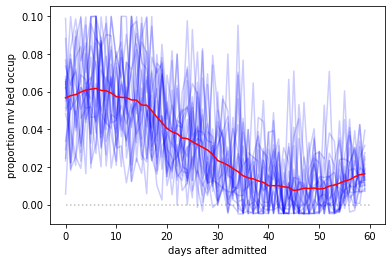

<Figure size 432x288 with 0 Axes>

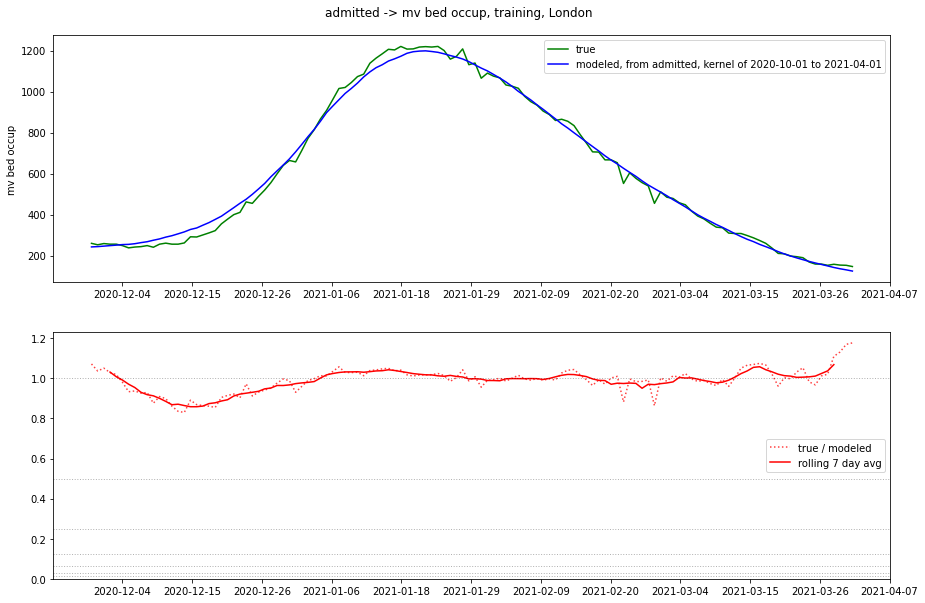

<Figure size 432x288 with 0 Axes>

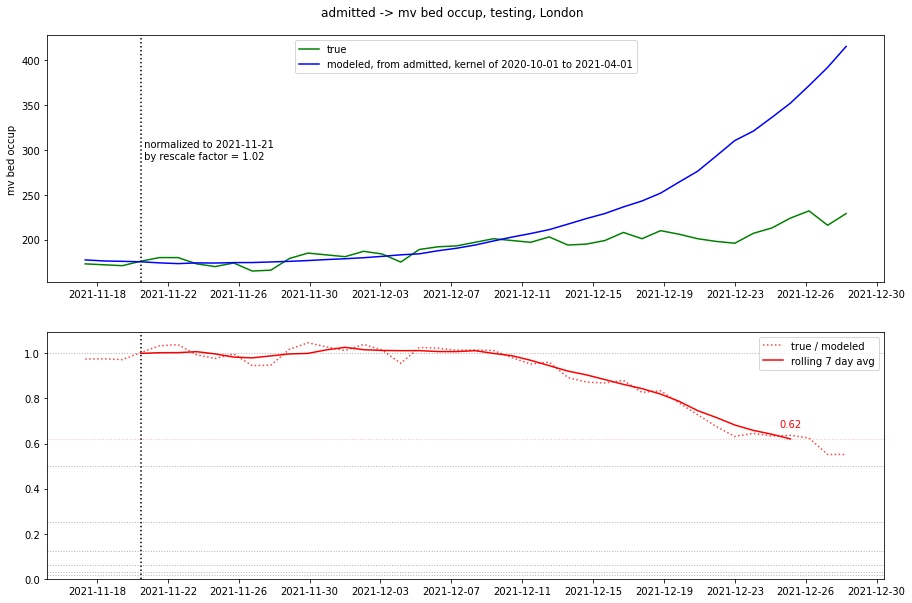

(1.0229328585946298, 0.6204756700134976)

In [11]:
# show kernel
plt.clf()
z = list(range(len(pos)))
for y in minimizers:
    plt.plot(z, y, color="blue", alpha=0.2)
avg_minimizer = []
for i in range(len(minimizers[0])):
    avg_minimizer.append(np.mean(minimizers[:,i]))
avg_minimizer = np.array(avg_minimizer)
avg_minimizer = N_avg_soft(avg_minimizer, 3) 
plt.plot(z, avg_minimizer, color="red", alpha=1)
plt.xlabel("days after %s" % in_event)
plt.ylabel("proportion %s" % out_event)
plt.hlines(0, 0,len(z), ls="dotted", alpha=0.25, color="black")
plt.savefig("%s__%s__kernel__%s.png" % (in_event, out_event, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#print("mass: %.2f" % np.sum(avg_minimizer))

# show fit to training & testing
def make_graph(dates, kernel, in_stream, out_stream, test_train):
    plt.clf()
    assert(len(in_stream)==len(out_stream))
    assert(len(kernel)<=len(in_stream))
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    ax1,ax2 = axes   
    
    true, pred = _f(avg_minimizer, in_stream, out_stream) 
    x = dates[-len(true):]
    diff = true/pred
    avg_diff = N_avg_hard(diff, 3)
    test_scale_factor = 1
    final_scale_factor = None
    if test_train=="test":
        test_scale_factor = avg_diff[np.isfinite(avg_diff)][0]
        pred *= test_scale_factor
        diff /= test_scale_factor
        avg_diff = N_avg_hard(diff, 3)
        final_scale_factor = avg_diff[np.isfinite(avg_diff)][-1]
    
    ax1.plot(x, true, color="green", label="true")
    modeled_label = "modeled, from %s, kernel of %s to %s" % (in_event, train_start_date, train_end_date)
    ax1.plot(x, pred, color="blue", label=modeled_label)
    ax1.set_ylabel("%s" % out_event)
    ax1.legend()
    n_marks = 11
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))
    
    ax2.plot(x, diff, color="red", alpha=0.75, ls="dotted", label="true / modeled") # unscaled
    ax2.plot(x, avg_diff, color="red", label="rolling 7 day avg")
    for i in range(7):
        ax2.axhline(y=2**(-i), ls="dotted", lw=1, alpha=0.3, color="black")        
    ax2.set_ylim(0,None)
    ax2.legend()
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))

    if test_train=="test":
        ax2.axvline(x=x[3], color="black", ls="dotted")
        ax1.axvline(x=x[3], color="black", ls="dotted")
        y_min,y_max = ax1.get_ylim()
        y_mid = (y_min+y_max)/2 
        ax1.text(x[3], y_mid, " normalized to %s\n by rescale factor = %.2f" % (x[3].strftime("%Y-%m-%d"), test_scale_factor), ha="left")
        ax2.axhline(y=final_scale_factor, color="red", alpha=0.25, ls="dotted", lw=1)
        ax2.text(x[-4], final_scale_factor+0.05, "%.2f" % (final_scale_factor), ha="center", color="red")    
    
    fig.suptitle("%s -> %s, %sing, %s" % (in_event, out_event, test_train, geographical_context), y=0.92)
    plt.savefig("%s__%s__%s__%s.png" % (in_event, out_event, test_train, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()
    return test_scale_factor, final_scale_factor
    
make_graph(dates_train, avg_minimizer, train_in_stream, train_out_stream, "train") 
make_graph(dates_test, avg_minimizer, test_in_stream, test_out_stream, "test") 





In [12]:
print(avg_minimizer)

[0.05659099 0.05779157 0.05838328 0.059738   0.06077542 0.06125628
 0.0616321  0.06059905 0.06039037 0.05919405 0.0572488  0.05689877
 0.05677024 0.05554565 0.05541098 0.05280597 0.0527339  0.04979608
 0.04643154 0.0434713  0.04038246 0.03858185 0.03759387 0.03531918
 0.03500143 0.03334845 0.03181953 0.03040659 0.02891487 0.02663501
 0.02330633 0.02220141 0.02090142 0.01912714 0.01743363 0.01525542
 0.01417772 0.01358969 0.01254279 0.01173945 0.01004178 0.01000209
 0.01006701 0.00937524 0.0090527  0.00742281 0.00786856 0.00865399
 0.00852577 0.00873036 0.00819038 0.00852254 0.00978537 0.01034202
 0.01129171 0.01242438 0.01314537 0.01469343 0.01579397 0.01628538]
